#Imported Libraries

In [23]:
!pip install pyspark

In [24]:
import urllib.request
from pyspark.sql import SparkSession
import time
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline
import urllib.request
from pyspark.sql.functions import col, size, lower, regexp_replace, avg
import matplotlib.pyplot as plt
import pandas as pd

#Extracting the data

In [25]:
# Initialize Spark session
spark = SparkSession.builder.appName("UCIDatasetFetch").getOrCreate()

# URL to the UCI dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"



#Loading the Data

In [26]:
# Creating the dataframe
local_path = "adult_dataset.csv"
urllib.request.urlretrieve(url, local_path)

# Creating the column names for the dataset
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
    "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
    "hours_per_week", "native_country", "income"
]
# Loading the dataset into a Spark DataFrame
reviews = spark.read.csv(local_path, header=False, inferSchema=True)
reviews = reviews.toDF(*columns)  # Assign column names

# Displaying the fetched data
reviews.show()

+---+-----------------+--------+-------------+-------------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+------+
|age|        workclass|  fnlwgt|    education|education_num|      marital_status|        occupation|  relationship|               race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+-----------------+--------+-------------+-------------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+------+
| 39|        State-gov| 77516.0|    Bachelors|         13.0|       Never-married|      Adm-clerical| Not-in-family|              White|   Male|      2174.0|         0.0|          40.0| United-States| <=50K|
| 50| Self-emp-not-inc| 83311.0|    Bachelors|         13.0|  Married-civ-spouse|   Exec-managerial|       Husband|              White|   Male|         0.0|         0.0|   

#Transforming the data

In [27]:
# Replication of the rows to simulate a larger dataset
num_replications = 10
larger_reviews = reviews
for _ in range(num_replications - 1):
    larger_reviews = larger_reviews.unionAll(reviews)

In [28]:
# Cleaning and preprocessing the text
start_time = time.time()
cleaned_reviews = larger_reviews.withColumn("cleaned_education", lower(regexp_replace(col("education"), "[^a-zA-Z\\s]", "")))
time_cleaning = time.time() - start_time

# Converting text into tokens
tokenizer = Tokenizer(inputCol="cleaned_education", outputCol="education_tokens")
start_time = time.time()
tokenized_reviews = tokenizer.transform(cleaned_reviews)
time_tokenization = time.time() - start_time

# Removal of common stop words
remover = StopWordsRemover(inputCol="education_tokens", outputCol="filtered_tokens")
start_time = time.time()
final_reviews = remover.transform(tokenized_reviews)
time_stopwords = time.time() - start_time


#Visulization of the data to get the better insights

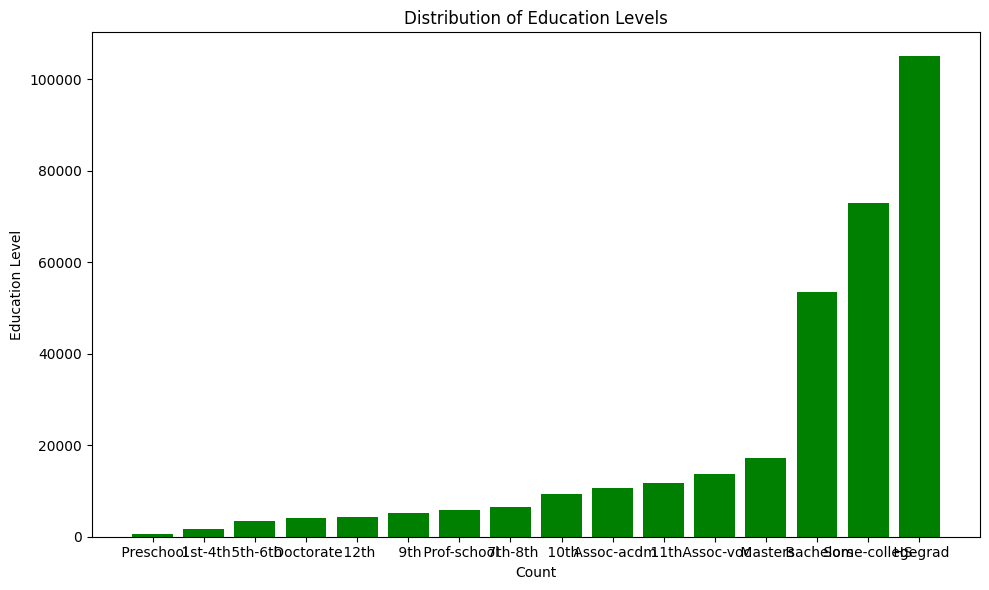

In [29]:
# Calculate education level distribution
education_distribution = larger_reviews.groupBy("education").count().orderBy("count")
education_distribution_pandas = education_distribution.toPandas()

# Distribution of Education Levels
plt.figure(figsize=(10, 6))
plt.bar(education_distribution_pandas["education"], education_distribution_pandas["count"], color="green")
plt.xlabel("Count")
plt.ylabel("Education Level")
plt.title("Distribution of Education Levels")
plt.tight_layout()
plt.show()

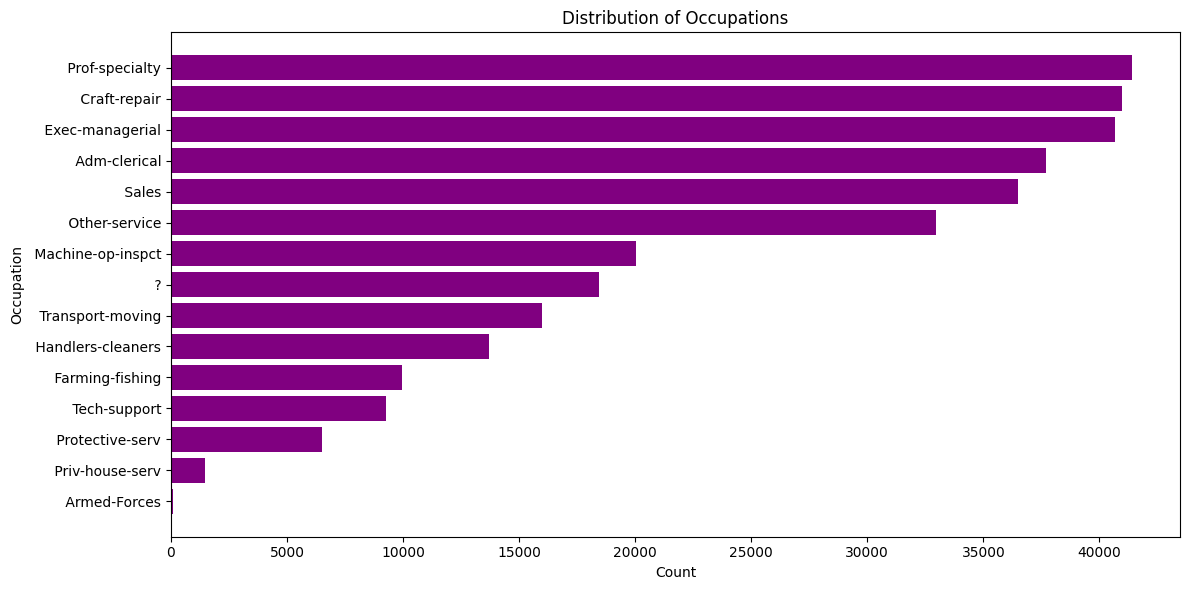

In [30]:
# occupation distribution
occupation_distribution = larger_reviews.groupBy("occupation").count().orderBy("count")
occupation_distribution_pandas = occupation_distribution.toPandas()

# Distribution of Occupations
plt.figure(figsize=(12, 6))
plt.barh(occupation_distribution_pandas["occupation"], occupation_distribution_pandas["count"], color="purple")
plt.xlabel("Count")
plt.ylabel("Occupation")
plt.title("Distribution of Occupations")
plt.tight_layout()
plt.show()

#Scalability and Time Analysis

In [31]:
# Time analysis results
print(f"Number of Rows: {larger_reviews.count()}")
print(f"Time taken for cleaning: {time_cleaning:.2f} seconds")
print(f"Time taken for tokenization: {time_tokenization:.2f} seconds")
print(f"Time taken for stop words removal: {time_stopwords:.2f} seconds")

# Stop the session
spark.stop()

Number of Rows: 325610
Time taken for cleaning: 0.03 seconds
Time taken for tokenization: 0.09 seconds
Time taken for stop words removal: 0.08 seconds
